# Detecting Anomalies

The purpose of this notebook is to detect abnormalities within a tensorboard scalar.

In [5]:
import re
import sys
import random

# Setup the "PYTHONPATH"
sys.path.insert(0, '../')

%matplotlib inline

from matplotlib import pyplot

In [35]:
import math

from src.utils import ExponentiallyWeightedMovingAverage

def get_running_mean_and_standard_deviation(steps, values, beta=0.9, sigma=8):
    """ Compute exponentially weighted running mean and standard deviation.
    
    Args:
        steps (list of float): Step at which each value occured.
        values (list of float): Values at each step.
        beta (float): Beta used to weight the exponential mean and standard deviation.
        sigma (float): Number of standard deviations before ignoring an abnormality.
        
    Returns:
        means (list of float): Exponentially weighted running means for each step.
        standard_deviations (list of float): Exponentially weighted running standard deviation for each step.
    """
    assert len(values) == len(steps)
    
    stats = ExponentiallyWeightedMovingAverage()
    means, standard_deviations = [], []
    average, variance = 0.0, 0.0
    last_abnormality = 0
    eps = 10**-6
    for i, (step, value) in enumerate(zip(steps, values)):
        # Detected abnormality
        # NOTE: ``i < 1`` then ``variance == 0.0``
        # NOTE: Above a sample size 10, we do not need to consider sample variance bias correction
        if i > 10 and abs(value - means[-1]) > standard_deviations[-1] * sigma + eps:
            if i > last_abnormality + 100:
                print('Detected abnormality (%f > %f ± %f), at step %d (step ignored)' %
                      (value, means[-1], standard_deviations[-1] * sigma, step))
            last_abnormality = i
            means.append(means[-1])
            standard_deviations.append(standard_deviations[-1])
        else:
            average, standard_deviation = stats.step(value)
            means.append(average)
            standard_deviations.append(standard_deviation)
    return means, standard_deviations

def load_tensorboard_data(path):
    """ Load a CSV file with 3 columns: wall_time, step, value
    
    Args:
        path (str): Path to the CSV file.
    """
    print('Loading data...')
    data = [row for row in open(path, 'r')]
    print('Header:', data[0].strip())
    data = [tuple([float(val) for val in row.strip().split(',')]) for row in data[1:]]
    print('Sample:', data[:5])
    _, step, value = zip(*data)
    return step, value

def plot(steps, values, beta=0.9, sigma=8):
    """ Plot values at steps with a running mean and standard deviation.
    
    Args:
        step (list of float): Step at which each value occured.
        value (list of float): Values at each step.
        means (list of float, optional): Exponentially weighted running means for each step.
        standard_deviations (list of float, optional): Exponentially weighted running standard deviation for
            each step.
        sigma (float): Number of standard deviations before ignoring an abnormality.      
    """
    print('Loading steps from %d to %d' % (steps[0], steps[-1]))
    print('Sigma: %f' % sigma)
    print('Beta: %f' % beta)
    means, standard_deviations = get_running_mean_and_standard_deviation(steps,
                                                                         values,
                                                                         beta=beta,
                                                                         sigma=sigma)
    pyplot.figure(figsize=(20, 10))
    pyplot.style.use('ggplot')
    kwargs = {
        'marker': '.',
        'linestyle': 'solid'
    }
    pyplot.plot(steps, values, label='Value', **kwargs)
    pyplot.plot(steps, means, label='Mean', **kwargs)

    upper_bound = [value + sigma * sd for value, sd in zip(means, standard_deviations)]
    lower_bound = [value - sigma * sd for value, sd in zip(means, standard_deviations)]

    pyplot.plot(steps, upper_bound, label='Upper Bound', **kwargs)
    pyplot.plot(steps, lower_bound, label='Lower Bound', **kwargs)
    
    pyplot.legend()
    pyplot.ylabel('Value')
    pyplot.xlabel('Step')

In [18]:
coarse_loss = load_tensorboard_data(
    '/tmp/csv_output/data_tb___coarse_loss_step.csv')

Loading data...
Header: wall_time,step,value
Sample: [(1533513088.4666336, 102.0, 5.572286128997803), (1533513143.6334746, 105.0, 5.343384742736816), (1533513143.9706004, 109.0, 4.772058963775635), (1533513144.3010392, 112.0, 4.208098888397217), (1533513144.6368492, 115.0, 4.0988616943359375)]


Loading steps from 102 to 1068164
Sigma: 6.000000
Beta: 0.990000


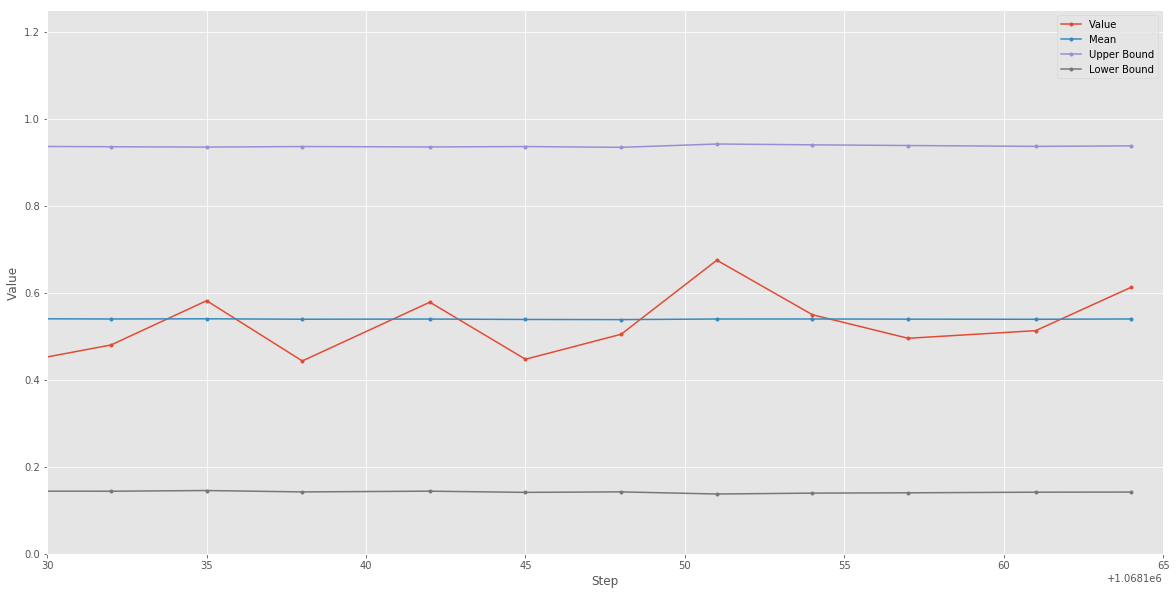

In [47]:
plot(*coarse_loss, sigma=6, beta=0.99)
_ = pyplot.axis([1068130, coarse_loss[0][-1] + 1, 0, 1.25])

In [20]:
max_grad_norm = load_tensorboard_data(
    '/tmp/csv_output/data_tb___max_grad_norm_step.csv')

Loading data...
Header: wall_time,step,value
Sample: [(1533513143.6265304, 105.0, 0.956061840057373), (1533513143.9564779, 109.0, 1.0056425333023071), (1533513144.294721, 112.0, 1.368690013885498), (1533513144.6305025, 115.0, 1.469247579574585), (1533513144.9549692, 119.0, 1.6582554578781128)]


Loading steps from 105 to 1068164
Sigma: 6.000000
Beta: 0.990000
Detected abnormality (16.109587 > 11.171695 ± 4.205467), at step 61910 (step ignored)
Detected abnormality (15.913183 > 10.549719 ± 4.474055), at step 75162 (step ignored)
Detected abnormality (12.907753 > 8.951265 ± 3.248959), at step 82775 (step ignored)
Detected abnormality (12.728679 > 8.633295 ± 3.341944), at step 94254 (step ignored)
Detected abnormality (10.060053 > 7.914183 ± 1.898182), at step 98258 (step ignored)
Detected abnormality (17.093933 > 8.925582 ± 6.979935), at step 99453 (step ignored)
Detected abnormality (11.768622 > 8.668378 ± 2.890047), at step 103360 (step ignored)
Detected abnormality (14.948291 > 8.856388 ± 3.789280), at step 112780 (step ignored)
Detected abnormality (207123840.000000 > 9.700895 ± 2.657700), at step 1068164 (step ignored)


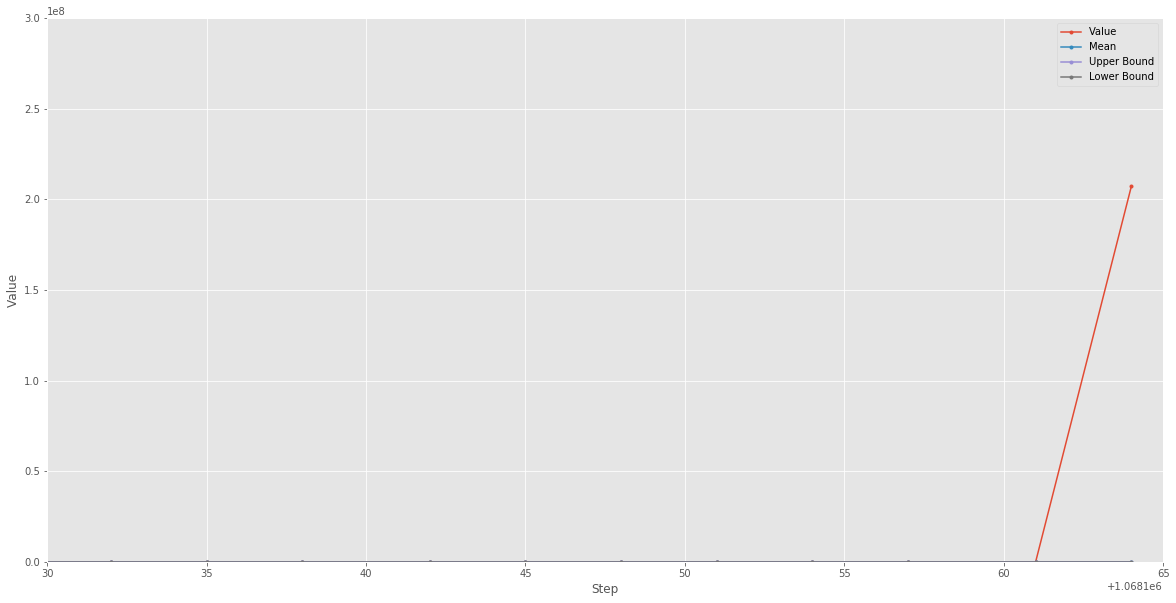

In [48]:
plot(*max_grad_norm, sigma=6, beta=0.99)
_ = pyplot.axis([1068130, max_grad_norm[0][-1] + 1, 0, 300000000])

In [43]:
parameter_norm = load_tensorboard_data(
    '/tmp/csv_output/data_tb___parameter_norm_step.csv')

Loading data...
Header: wall_time,step,value
Sample: [(1533513088.455998, 102.0, 0.956061840057373), (1533513143.6294057, 105.0, 1.05472731590271), (1533513143.9609005, 109.0, 2.083930015563965), (1533513144.2973413, 112.0, 1.764926791191101), (1533513144.63311, 115.0, 2.3955745697021484)]


Loading steps from 102 to 1068164
Sigma: 21.000000
Beta: 0.990000
Detected abnormality (237.901428 > 10.534024 ± 226.419498), at step 54620 (step ignored)
Detected abnormality (306.541290 > 11.496000 ± 266.082446), at step 54973 (step ignored)
Detected abnormality (382.041412 > 11.061887 ± 217.783284), at step 55461 (step ignored)
Detected abnormality (452.750946 > 11.865625 ± 351.934480), at step 60175 (step ignored)
Detected abnormality (332.524384 > 10.703909 ± 223.207602), at step 61904 (step ignored)
Detected abnormality (336.103821 > 10.717619 ± 258.257514), at step 75156 (step ignored)
Detected abnormality (212.712479 > 8.932473 ± 185.481692), at step 76559 (step ignored)
Detected abnormality (269.450500 > 9.462603 ± 195.632305), at step 78360 (step ignored)
Detected abnormality (233.582123 > 8.968603 ± 221.014341), at step 82768 (step ignored)
Detected abnormality (178.146942 > 8.913139 ± 167.583560), at step 86224 (step ignored)
Detected abnormality (168.006638 > 8.673229 ± 15

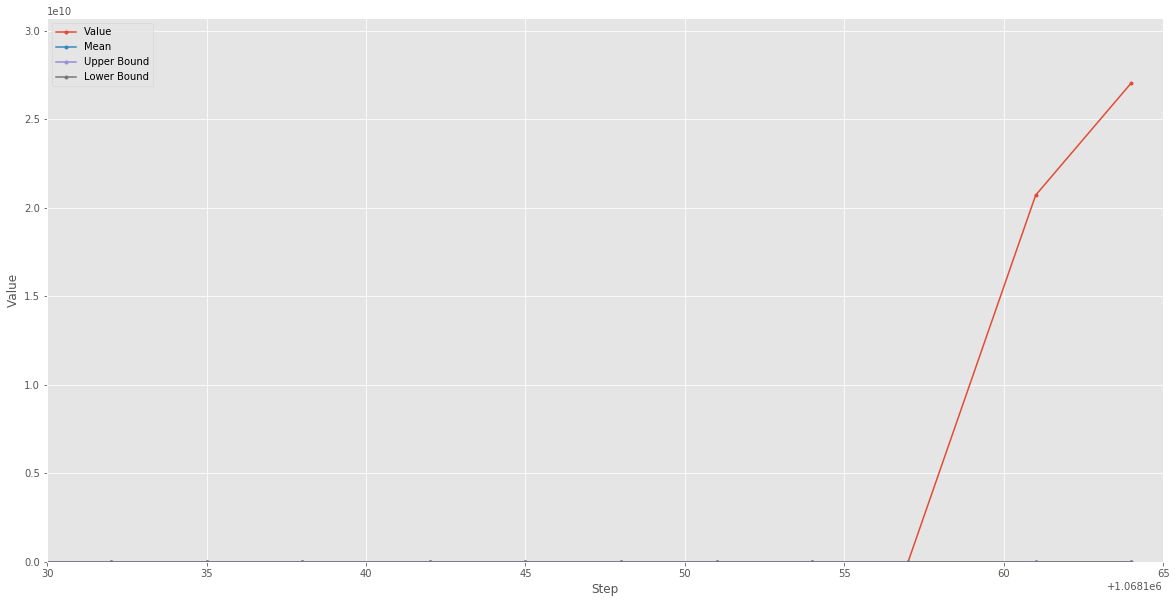

In [54]:
plot(*parameter_norm, sigma=21, beta=0.99)
_ = pyplot.axis([1068130, parameter_norm[0][-1] + 1, 0, 30712382464])

In [56]:
len(parameter_norm[0]) / 13100

25.17290076335878